In [1]:
import bbknn
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore') 

/software/conda/users/pm19/sc/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_h5ad('/lustre/scratch127/cellgen/cellgeni/tmp/scvi_integrated_d43larry_refSKO_04Nov2025.h5ad')
del adata.obsp['connectivities']
del adata.obsp['distances']
adata

AnnData object with n_obs × n_vars = 153691 × 2000
    obs: 'barcodes', 'sanger_id', 'Clone', 'Barcode', 'Barcode_n', 'sing_or_mult', 'batch', '_is_larry', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'pct_counts_in_top_20_genes', 'sanger_ID', 'outlier', 'outlier_pct_ribo', 'QC', 'unint_leiden_res_0.02', 'unint_leiden_res_0.50', 'unint_leiden_res_1.00', 'unint_leiden_res_2.00', 'unint_leiden_res_2.50', 'unint_leiden_res_3.00', 'Clone_id', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'annot0_manual', 'Batch', 'Clone_id_seq', 'sample_ID', 'sanger_study_ID', 'haniffa_lab_project', 'technology', 'modality', 'cell_or_nuclei', 'technical_r

In [3]:
reasso = {"7785STDY16123308": "non_reasso",
         "7785STDY16123307": "reasso",
         "7785STDY16123306": "reasso",
         "7785STDY16123305": "reasso"}

adata.obs['_is_reasso'] = adata.obs['sanger_id'].map(reasso)
adata.obs['_is_reasso'].value_counts()

_is_reasso
non_reasso    6490
reasso        4167
Name: count, dtype: int64

In [4]:
bbknn.bbknn(adata,use_rep='X_scVI',batch_key='batch',neighbors_within_batch=20) # neighbors_within_batch=50?
adata

AnnData object with n_obs × n_vars = 153691 × 2000
    obs: 'barcodes', 'sanger_id', 'Clone', 'Barcode', 'Barcode_n', 'sing_or_mult', 'batch', '_is_larry', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'pct_counts_in_top_20_genes', 'sanger_ID', 'outlier', 'outlier_pct_ribo', 'QC', 'unint_leiden_res_0.02', 'unint_leiden_res_0.50', 'unint_leiden_res_1.00', 'unint_leiden_res_2.00', 'unint_leiden_res_2.50', 'unint_leiden_res_3.00', 'Clone_id', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'annot0_manual', 'Batch', 'Clone_id_seq', 'sample_ID', 'sanger_study_ID', 'haniffa_lab_project', 'technology', 'modality', 'cell_or_nuclei', 'technical_r

In [5]:
def annotateByKnn(data,knn_key,ann_key,agg_fun):
    knn = data.obsp[knn_key]
    res = []
    for row in range(data.shape[0]):
        inxs = knn.indices[knn.indptr[row]:knn.indptr[row+1]]
        inxs = [i for i in inxs if  i != row]
        r = data.obs[ann_key][inxs]
        res.append(agg_fun(r))
    res=pd.DataFrame(res)
    res.index = data.obs_names
    return res

def agg(x):
    return [x.mean(),x.std(),x.median(),(~x.isna()).sum()]

In [6]:
adata.obs['age_years_ref'] = adata.obs.age_years.copy()
adata.obs['age_years_ref'] = adata.obs['age_years_ref'].astype(str).astype(float)
adata.obs['age_years_ref'][adata.obs.batch=='larry'] = pd.NA
adata.obs['age_years_ref'].value_counts(dropna=False)

age_years_ref
112.0    26200
96.0     19880
133.0    19670
131.0    19639
70.0     18396
29.0     15184
83.0     12820
NaN      10657
50.0      7100
14.0      4145
Name: count, dtype: int64

In [7]:
adata.obs['age_years_ref']

AAACCCACACTGTCGG-7785STDY16123305-d43-8-d43-larry      NaN
AAACGCTGTGAGGAAA-7785STDY16123305-d43-8-d43-larry      NaN
AAAGAACGTCAAACGG-7785STDY16123305-d43-8-d43-larry      NaN
AAAGAACGTCACCTTC-7785STDY16123305-d43-8-d43-larry      NaN
AAAGAACTCAGGAAAT-7785STDY16123305-d43-8-d43-larry      NaN
                                                     ...  
CTATAGGCACGATAGG-1-HCA_SkO13801444-13-ref            133.0
GACCCAGGTGAGTGAC-1-HCA_SkO13801444-13-ref            133.0
CTGCCTATCAAATAGG-1-HCA_SkO13801444-13-ref            133.0
GATGAGGAGGTAACTA-1-HCA_SkO13801444-13-ref            133.0
TACCTCGAGGACAAGA-1-HCA_SkO13801444-13-ref            133.0
Name: age_years_ref, Length: 153691, dtype: float64

In [8]:
(~adata.obs.age_years_ref.isna()).sum()

np.int64(143034)

In [9]:
pred_age = annotateByKnn(adata,knn_key = 'distances',ann_key = 'age_years_ref',agg_fun=agg)
pred_age.columns = ['mean','std','median','N']
pred_age


,mean,std,median,N
AAACCCACACTGTCGG-7785STDY16123305-d43-8-d43-larry,94.300000,22.100488,97.5,20
AAACGCTGTGAGGAAA-7785STDY16123305-d43-8-d43-larry,80.100000,26.897270,83.0,20
AAAGAACGTCAAACGG-7785STDY16123305-d43-8-d43-larry,80.300000,30.509878,70.0,20
AAAGAACGTCACCTTC-7785STDY16123305-d43-8-d43-larry,82.500000,43.445671,70.0,20
AAAGAACTCAGGAAAT-7785STDY16123305-d43-8-d43-larry,91.650000,19.580535,89.5,20
...,...,...,...,...
CTATAGGCACGATAGG-1-HCA_SkO13801444-13-ref,129.473684,7.798635,133.0,19
GACCCAGGTGAGTGAC-1-HCA_SkO13801444-13-ref,116.736842,21.319897,131.0,19
CTGCCTATCAAATAGG-1-HCA_SkO13801444-13-ref,92.736842,41.657122,131.0,19
GATGAGGAGGTAACTA-1-HCA_SkO13801444-13-ref,116.263158,33.970317,131.0,19


In [10]:
adata.obs['pred_age_mean'] = pred_age['mean']
adata.obs['pred_age_std'] = pred_age['std']
adata.obs[['pred_age_mean','pred_age_std']] 

,pred_age_mean,pred_age_std
AAACCCACACTGTCGG-7785STDY16123305-d43-8-d43-larry,94.300000,22.100488
AAACGCTGTGAGGAAA-7785STDY16123305-d43-8-d43-larry,80.100000,26.897270
AAAGAACGTCAAACGG-7785STDY16123305-d43-8-d43-larry,80.300000,30.509878
AAAGAACGTCACCTTC-7785STDY16123305-d43-8-d43-larry,82.500000,43.445671
AAAGAACTCAGGAAAT-7785STDY16123305-d43-8-d43-larry,91.650000,19.580535
...,...,...
CTATAGGCACGATAGG-1-HCA_SkO13801444-13-ref,129.473684,7.798635
GACCCAGGTGAGTGAC-1-HCA_SkO13801444-13-ref,116.736842,21.319897
CTGCCTATCAAATAGG-1-HCA_SkO13801444-13-ref,92.736842,41.657122
GATGAGGAGGTAACTA-1-HCA_SkO13801444-13-ref,116.263158,33.970317


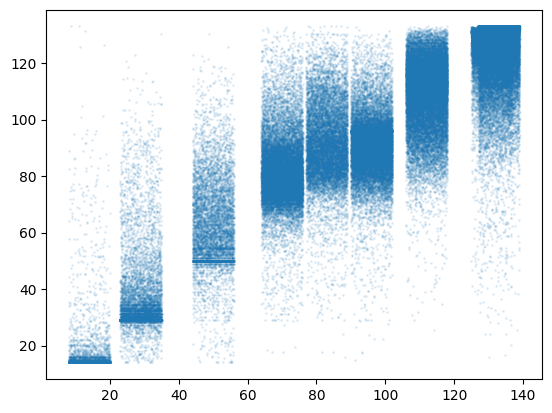

In [11]:
# check how prediction works for reference (where we know the truth)
x_jittered = adata.obs.age_years_ref + np.random.uniform(-6, 6, size=adata.shape[0])

plt.scatter(x_jittered,pred_age['mean'],s=1, alpha=0.1)

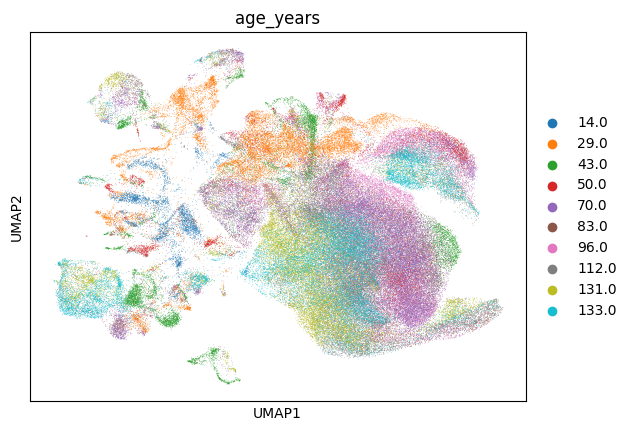

In [12]:
sc.pl.umap(adata,color=['age_years'])

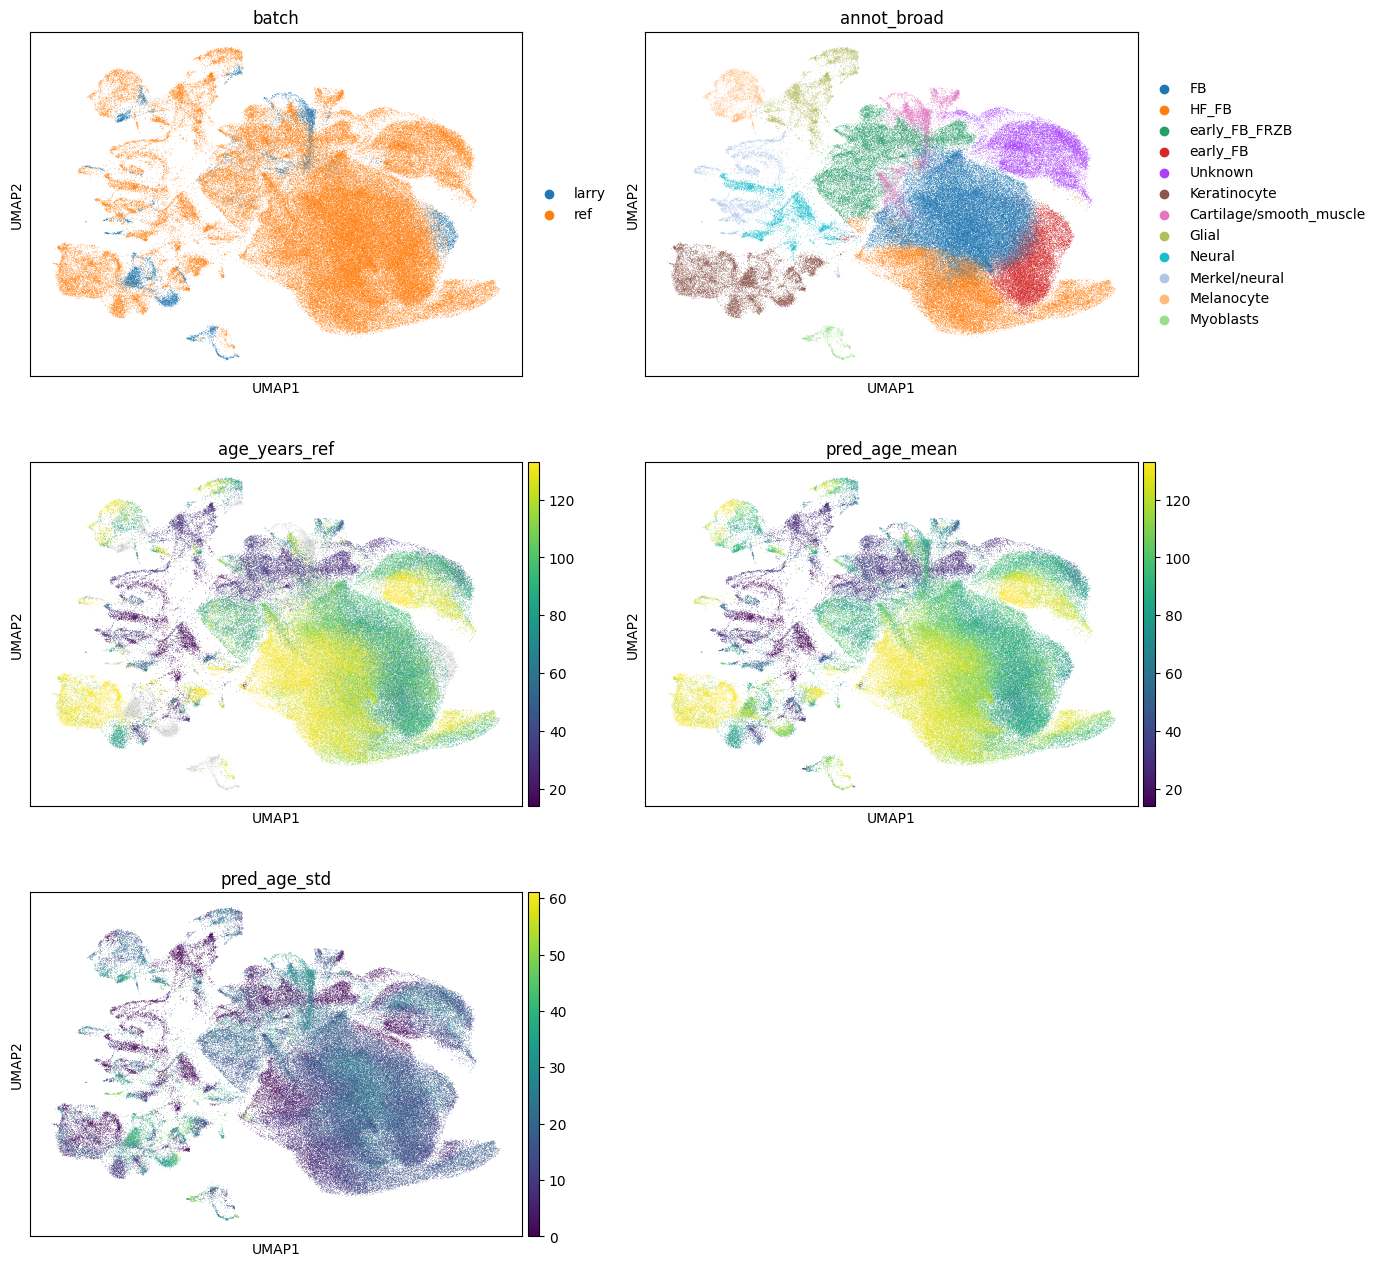

In [13]:
sc.pl.umap(adata,color=['batch','annot_broad','age_years_ref','pred_age_mean','pred_age_std'],ncols=2)

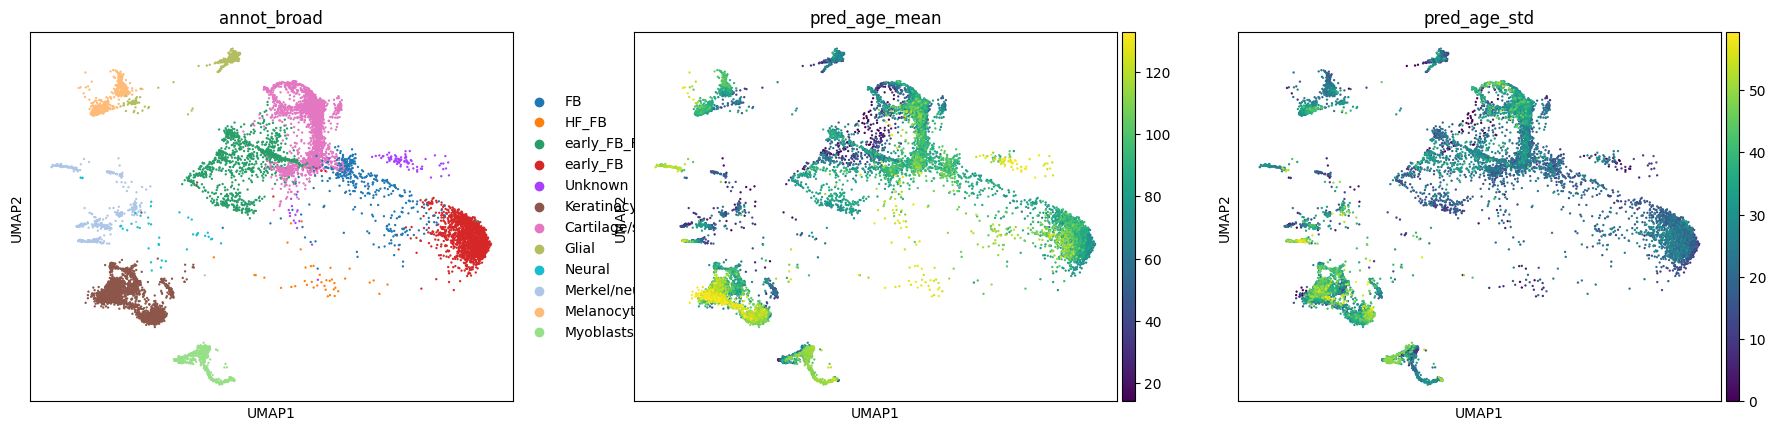

In [14]:
sc.pl.umap(adata[adata.obs.batch=='larry'],color=['annot_broad','pred_age_mean','pred_age_std'])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(1, 0, 'FB'),
  Text(2, 0, 'HF_FB'),
  Text(3, 0, 'early_FB_FRZB'),
  Text(4, 0, 'early_FB'),
  Text(5, 0, 'Unknown'),
  Text(6, 0, 'Keratinocyte'),
  Text(7, 0, 'Cartilage/smooth_muscle'),
  Text(8, 0, 'Glial'),
  Text(9, 0, 'Neural'),
  Text(10, 0, 'Merkel/neural'),
  Text(11, 0, 'Melanocyte'),
  Text(12, 0, 'Myoblasts')])

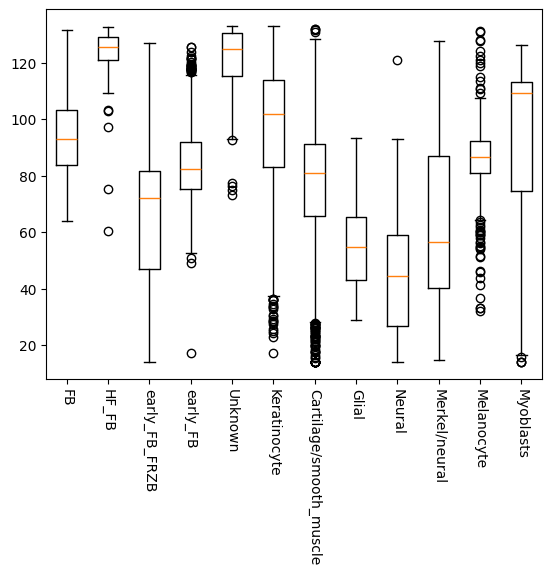

In [15]:
groups = adata.obs[adata.obs.batch=='larry'].groupby('annot_broad')['pred_age_mean'].apply(list)

z=plt.boxplot(groups, labels=groups.index)
plt.xticks(rotation=-90)

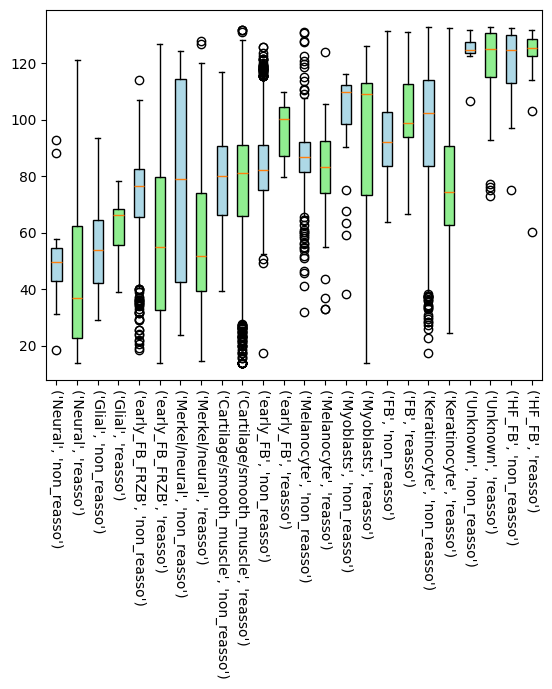

In [16]:
groups = adata.obs[adata.obs.batch=='larry'].groupby(['annot_broad','_is_reasso'])['pred_age_mean'].apply(list)
order = adata.obs[adata.obs.batch=='larry'].groupby(['annot_broad'])['pred_age_mean'].mean().sort_values().index
groups = groups[order]

boxes=plt.boxplot(groups, labels=groups.index,patch_artist=True)
colors = ['lightblue', 'lightgreen']

for i in range(len(boxes['boxes'])):
    boxes['boxes'][i].set_facecolor(colors[i % 2])

z=plt.xticks(rotation=-90)

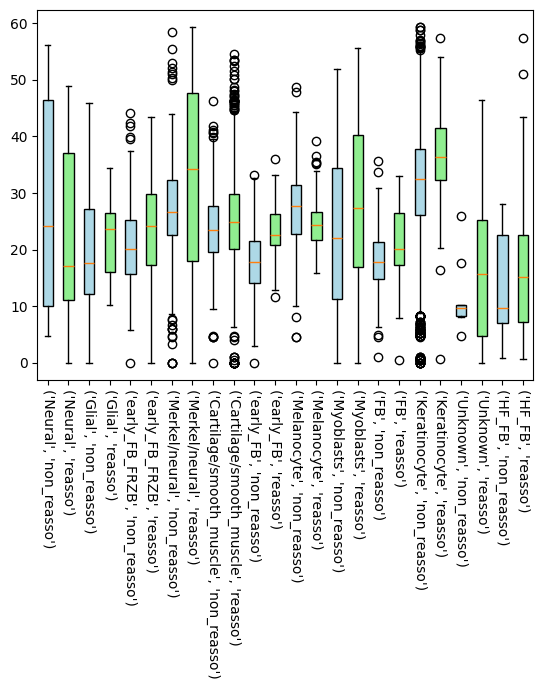

In [17]:
groups = adata.obs[adata.obs.batch=='larry'].groupby(['annot_broad','_is_reasso'])['pred_age_std'].apply(list)
groups = groups[order]

boxes=plt.boxplot(groups, labels=groups.index,patch_artist=True)
colors = ['lightblue', 'lightgreen']

for i in range(len(boxes['boxes'])):
    boxes['boxes'][i].set_facecolor(colors[i % 2])

z=plt.xticks(rotation=-90)

In [18]:
ra =adata.obs.loc[(adata.obs.batch=='larry') & (adata.obs['_is_reasso'] == 'reasso')].groupby(['annot_broad'])['pred_age_mean'].mean()
nr =adata.obs.loc[(adata.obs.batch=='larry') & (adata.obs['_is_reasso'] != 'reasso')].groupby(['annot_broad'])['pred_age_mean'].mean()
mean_ages = pd.DataFrame({'reasso':ra,
                          'non_reasso':nr})
mean_ages

,reasso,non_reasso
annot_broad,,
FB,101.830556,93.828846
HF_FB,122.160000,118.360000
early_FB_FRZB,55.761392,72.235277
early_FB,96.817143,84.527497
Unknown,119.901744,123.922222
Keratinocyte,76.402632,98.376391
Cartilage/smooth_muscle,77.773263,78.773966
Glial,62.316667,53.623242
Neural,42.786207,52.386364


Text(0, 0.5, 'non_reasso')

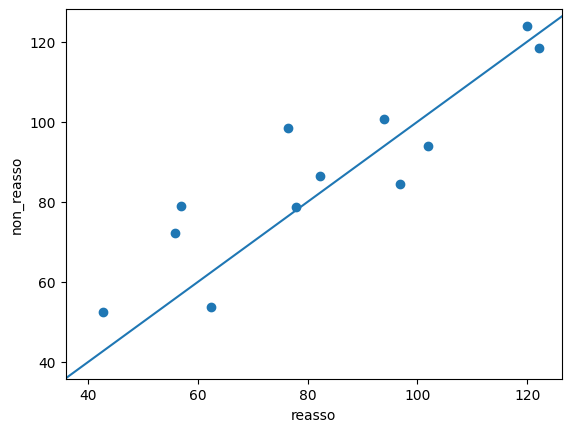

In [19]:
plt.scatter(mean_ages.reasso,mean_ages.non_reasso)
plt.axline([40,40],[41,41])
plt.xlabel("reasso")
plt.ylabel("non_reasso")